# import Modules 

In [84]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [85]:
#DATA\TRAIN
#DATA\BOUNDING BOX
IMAGE_DIR=r'D:\DS-Class\Sep_Proj\Pro_1\data\dataset\training_images'
CSV_PATH=r'data/dataset/train_solution_bounding_boxes (1).csv'

In [86]:
df=pd.read_csv(CSV_PATH)
df.tail()

image        xmin        ymin        xmax        ymax
554  vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555  vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556  vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557  vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558  vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

# Visualize Bounding Boxes

In [87]:
def visualize_image(image_name):
    image_path=os.path.join(IMAGE_DIR,image_name)
    image=Image.open(image_path)
    fig,ax=plt.subplots(1)
    ax.imshow(image)

    boxes=df[df['image']==image_name]
    for _,row in boxes.iterrows():
        xmin,ymin,xmax,ymax=row['xmin'],row['ymin'],row['xmax'],row['ymax']
        width=xmax-xmin
        height= ymax-ymin
        rect=patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor='green',facecolor='none')
        ax.add_patch(rect)
    plt.title(image_name)
    plt.axis('off')
    plt.show()

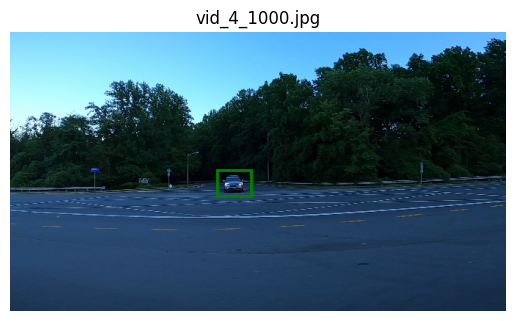

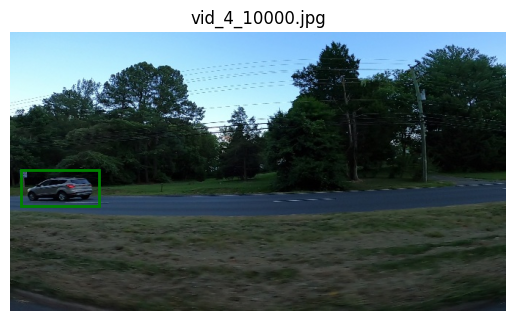

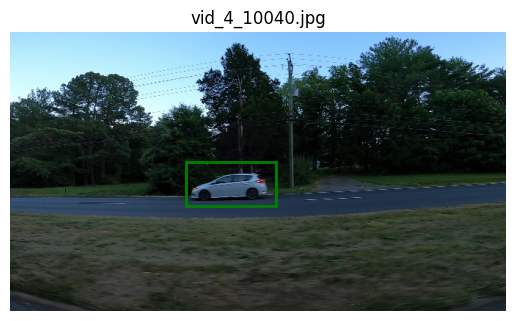

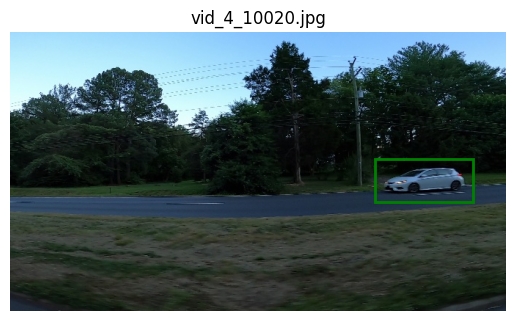

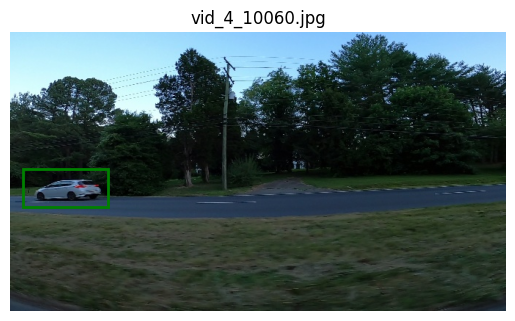

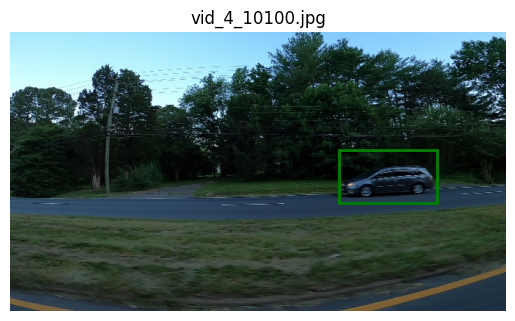

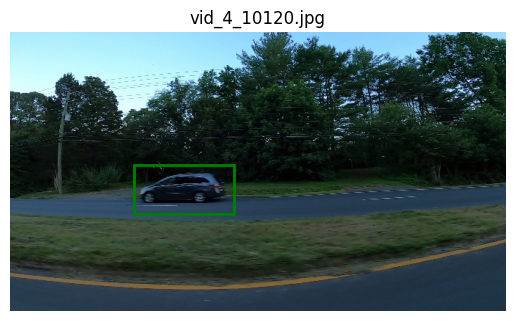

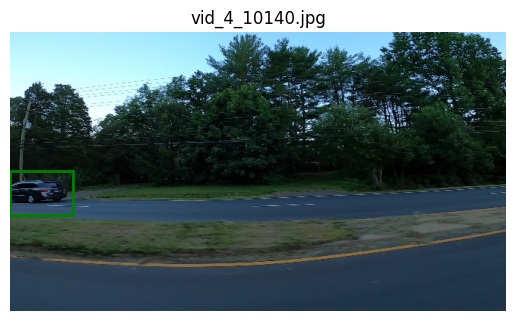

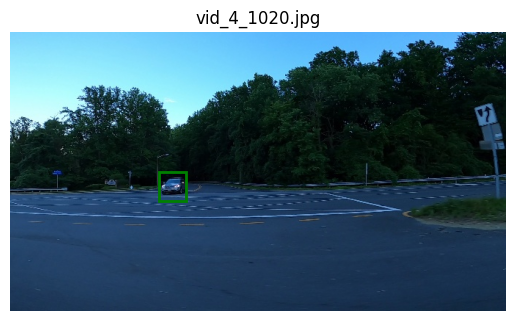

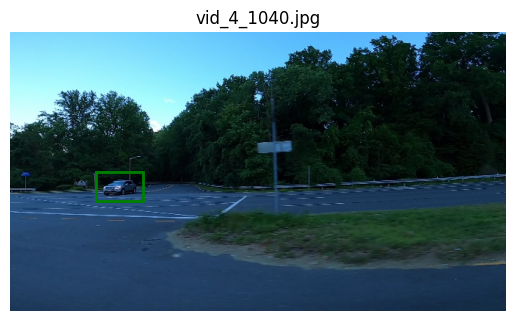

In [88]:
sample_image=df['image'].unique()[:10]
for img in sample_image:
    visualize_image(img)

 # Convert to yolo FORMAT & create Label File

In [89]:
YOLO_LABEL_DIR=r'D:\DS-Class\Sep_Proj\Pro_1\data\yolo_labels'
os.makedirs(YOLO_LABEL_DIR,exist_ok=True)

df['label']='car'
class_map={'car':0}

In [90]:
for image_name in df['image'].unique():
    image_path=os.path.join(IMAGE_DIR,image_name)
    with Image.open(image_path) as img:
        w,h=img.size

boxes=df[df['image']==image_name]
yolo_line=[]
for _ ,row in boxes.iterrows():
    class_id =class_map[row['label']]
    x_center=((row['xmin'] + row['xmax'])/2) /w
    y_center=((row['ymin'] + row['ymax'])/2) /h
    width=(row['xmax']-row['xmin']) /w
    heigh=(row['ymax']-row['ymin']) /h
    yolo_line.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {heigh:.6f}")

#"dog1.jpg" → "dog1.txt"
label_filename = os.path.splitext(image_name)[0] + '.txt'
label_path=os.path.join(YOLO_LABEL_DIR,label_filename)
with open(label_path,'w')as f:
    f.write('\n'.join(yolo_line))
  

In [91]:
from sklearn.model_selection import train_test_split
import shutil

BASE_DIR=r'D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset'
IMAGES_DIR = os.path.join(BASE_DIR, "images")
LABELS_DIR = os.path.join(BASE_DIR, "labels")

for split in ["train", "val"]:
    os.makedirs(os.path.join(IMAGES_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(LABELS_DIR, split), exist_ok=True)

In [92]:
image_list = df['image'].unique()
train_imgs, val_imgs = train_test_split(image_list, test_size=0.2, random_state=42)

In [93]:
def copy_files(image_names, subset):
    for img in image_names:
        shutil.copy(os.path.join(IMAGE_DIR, img), os.path.join(IMAGES_DIR, subset, img))
        label_file = img.replace(".jpg", ".txt")
        src_label_path = os.path.join(YOLO_LABEL_DIR, label_file)
        dst_label_path = os.path.join(LABELS_DIR, subset, label_file)
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)

copy_files(train_imgs, "train")
copy_files(val_imgs, "val")


In [ ]:
yaml_content = """
train: "D:/DS-Class/Sep_Proj/Pro_1/data/yolo_dataset/images/train"
val: "D:/DS-Class/Sep_Proj/Pro_1/data/yolo_dataset/images/val"

nc: 1
names: ["car"]
"""

yaml_path = r'D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\car_dataset.yaml'
with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print("✅ car_dataset.yaml file created correctly.")

✅ car_dataset.yaml file created correctly.


In [103]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Nano version

model.train(
    data=yaml_path,
    epochs=20,
    imgsz=640,
    batch=8,
    name="car_detector_model"
)


Ultralytics 8.3.127  Python-3.10.0 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10400F 2.90GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\car_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_detector_model12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

100%|██████████| 755k/755k [00:00<00:00, 16.8MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access  (ping: 0.10.0 ms, read: 17.53.0 MB/s, size: 106.1 KB)


train: Scanning D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\labels\train... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<00:00, 612.16it/s]

train: New cache created: D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\labels\train.cache


val: Fast image access  (ping: 0.00.0 ms, read: 21.55.2 MB/s, size: 103.4 KB)


val: Scanning D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\labels\val... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 646.49it/s]


val: New cache created: D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\labels\val.cache
Plotting labels to runs\detect\car_detector_model12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\car_detector_model12
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.473      2.225      1.141          6        640: 100%|██████████| 36/36 [01:52<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]

                   all         71        119     0.0054      0.966      0.674      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.329      1.456      1.172         10        640: 100%|██████████| 36/36 [01:53<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]

                   all         71        119          1       0.34      0.809      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.338      1.267      1.127          7        640: 100%|██████████| 36/36 [01:48<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]

                   all         71        119       0.95      0.793      0.879       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.318      1.206      1.147          7        640: 100%|██████████| 36/36 [01:52<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

                   all         71        119      0.986      0.908      0.949      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.306      1.127      1.123          8        640: 100%|██████████| 36/36 [02:07<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]

                   all         71        119      0.978      0.924      0.962      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.276      1.061      1.114         13        640: 100%|██████████| 36/36 [02:00<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]

                   all         71        119      0.981      0.924      0.959      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.249      0.979      1.096          7        640: 100%|██████████| 36/36 [01:57<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]

                   all         71        119      0.945      0.916      0.965        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.255     0.9435      1.094         15        640: 100%|██████████| 36/36 [02:07<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

                   all         71        119      0.967      0.933      0.955      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.225     0.8748      1.099         14        640: 100%|██████████| 36/36 [02:07<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]

                   all         71        119      0.989      0.924       0.97       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.204     0.8179      1.084         11        640: 100%|██████████| 36/36 [02:03<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]

                   all         71        119      0.991       0.94      0.974       0.63


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.181     0.9855      1.083          8        640: 100%|██████████| 36/36 [02:08<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]

                   all         71        119       0.98       0.95      0.979       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.161     0.8863      1.065          6        640: 100%|██████████| 36/36 [02:07<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

                   all         71        119      0.965      0.941      0.965      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.117     0.8559       1.06          4        640: 100%|██████████| 36/36 [01:58<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]

                   all         71        119      0.981      0.941      0.976      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.132     0.8302      1.058          4        640: 100%|██████████| 36/36 [01:59<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]

                   all         71        119      0.974      0.944       0.98      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.131     0.7838      1.047          4        640: 100%|██████████| 36/36 [02:05<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]

                   all         71        119      0.974      0.949      0.976      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.106     0.7723      1.051          7        640: 100%|██████████| 36/36 [02:02<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]

                   all         71        119      0.979       0.95      0.983      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.124     0.7545      1.066          4        640: 100%|██████████| 36/36 [02:02<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

                   all         71        119      0.974      0.948      0.971      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.081     0.7328       1.05          4        640: 100%|██████████| 36/36 [02:01<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

                   all         71        119      0.982      0.941      0.965      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.084      0.713      1.063          5        640: 100%|██████████| 36/36 [01:59<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]

                   all         71        119      0.977      0.941      0.967      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.053     0.6984       1.03          5        640: 100%|██████████| 36/36 [02:00<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]

                   all         71        119      0.958      0.951      0.971      0.634



20 epochs completed in 0.711 hours.
Optimizer stripped from runs\detect\car_detector_model12\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\car_detector_model12\weights\best.pt, 6.2MB

Validating runs\detect\car_detector_model12\weights\best.pt...
Ultralytics 8.3.127  Python-3.10.0 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10400F 2.90GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


                   all         71        119      0.977      0.941      0.967      0.641
Speed: 2.2ms preprocess, 71.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\car_detector_model12


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000026DE4A1D210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

# EVALUVATION

## 1.Load Trained Model for inference

In [2]:
from ultralytics import YOLO
model = YOLO('D:\DS-Class\Sep_Proj\Pro_1\yolov8n.pt')

## 2. Run Inference on Validation Images

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

VAL_DIR=r'D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val'

# Get list of validation images
val_images = [f for f in os.listdir(VAL_DIR) if f.endswith('.jpg')]

# Run inference on a few images
results = []
for img_name in val_images[:5]:  # Show predictions on first 5 images
    img_path = os.path.join(VAL_DIR, img_name)
    result = model(img_path)
    results.append(result)
    result[0].show()  # Visualize with bounding boxes


image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10020.jpg: 384x640 1 car, 79.5ms
Speed: 2.0ms preprocess, 79.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10100.jpg: 384x640 1 car, 59.7ms
Speed: 1.6ms preprocess, 59.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_1040.jpg: 384x640 1 car, 57.3ms
Speed: 2.3ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10980.jpg: 384x640 2 cars, 170.5ms
Speed: 4.2ms preprocess, 170.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_11400.jpg: 384x640 1 car, 1496.2ms
Speed: 22.1ms preprocess, 1496.2ms inference, 6.9ms postprocess per image at s


image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10020.jpg: 384x640 1 car, 94.1ms
Speed: 2.0ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


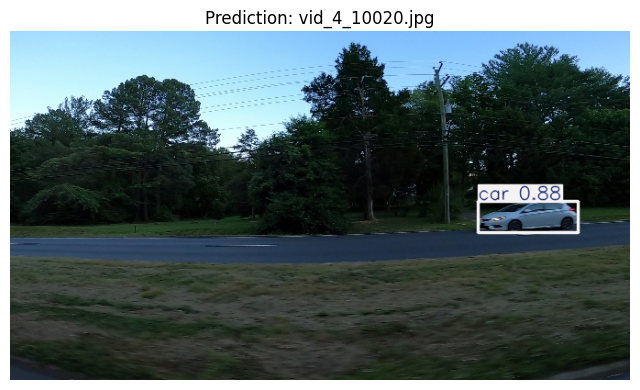


image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10100.jpg: 384x640 1 car, 63.1ms
Speed: 3.2ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


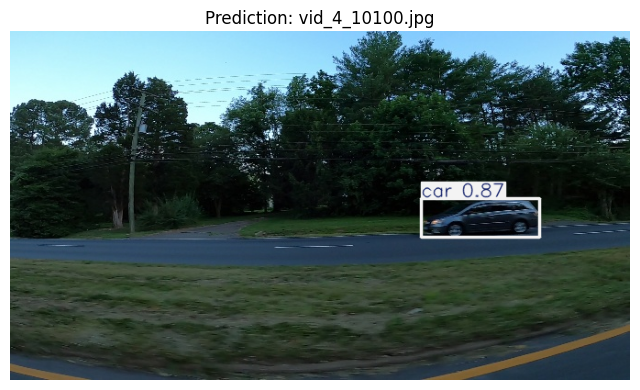


image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_1040.jpg: 384x640 1 car, 53.8ms
Speed: 1.9ms preprocess, 53.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


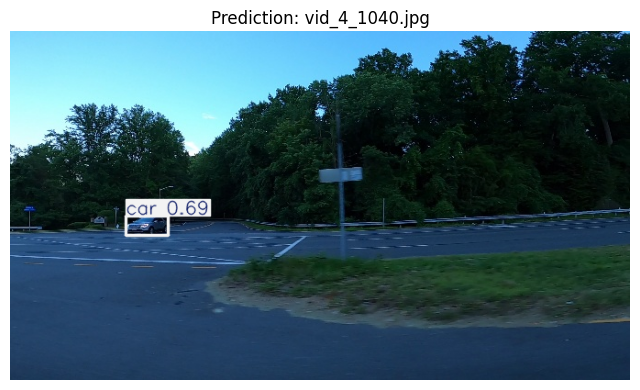


image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10980.jpg: 384x640 2 cars, 55.9ms
Speed: 2.2ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


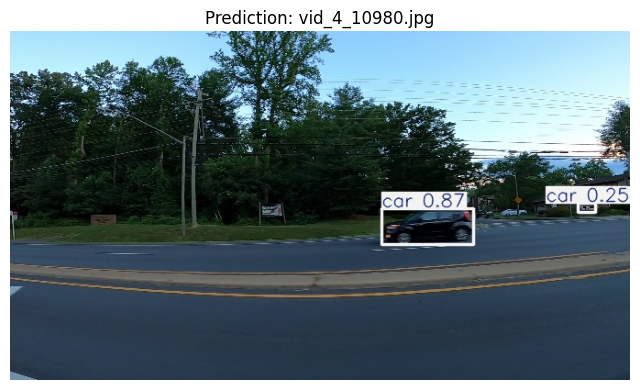


image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_11400.jpg: 384x640 1 car, 55.1ms
Speed: 1.8ms preprocess, 55.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


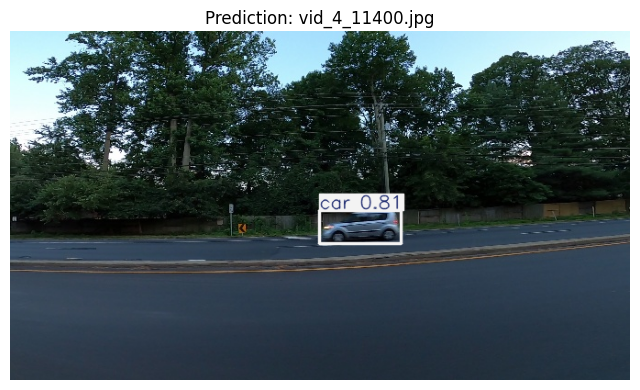

In [4]:
import cv2
import numpy as np

for img_name in val_images[:5]:
    img_path = os.path.join(VAL_DIR, img_name)
    result = model(img_path)

    # Get rendered image from result object (as array)
    rendered_img = result[0].plot()

    # Convert BGR (OpenCV format) to RGB for matplotlib
    rendered_img_rgb = cv2.cvtColor(rendered_img, cv2.COLOR_BGR2RGB)

    # Show in notebook
    plt.figure(figsize=(8, 6))
    plt.imshow(rendered_img_rgb)
    plt.title(f"Prediction: {img_name}")
    plt.axis("off")
    plt.show()


## 3. Evaluation Metrics (Precision, Recall, mAP)

In [5]:
# Evaluate model on validation set using your dataset.yaml
metrics=model.val(data=r'D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\car_dataset.yaml')

Ultralytics 8.3.127  Python-3.10.0 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10400F 2.90GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 188.745.0 MB/s, size: 120.0 KB)


val: Scanning D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\labels\val.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


                   all         71        119    0.00518     0.0084    0.00307    0.00147
                person         71        119    0.00518     0.0084    0.00307    0.00147
Speed: 1.4ms preprocess, 63.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val3


In [7]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("D:\DS-Class\Sep_Proj\Pro_1\yolov8n.pt")

# Run validation
metrics = model.val()

Ultralytics 8.3.127  Python-3.10.0 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10400F 2.90GHz)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 25.96.7 MB/s, size: 166.4 KB)


val: Scanning D:\DS-Class\Sep_Proj\Pro_1\datasets\coco\labels\val2017... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:16<00:00, 301.86it/s]


val: New cache created: D:\DS-Class\Sep_Proj\Pro_1\datasets\coco\labels\val2017.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [07:39<00:00,  1.47s/it]


                   all       5000      36335      0.635      0.474      0.521      0.372
                person       2693      10777      0.757      0.671      0.745      0.515
               bicycle        149        314      0.692      0.392      0.457      0.264
                   car        535       1918      0.651      0.513      0.562      0.365
            motorcycle        159        367      0.715       0.58      0.659      0.414
              airplane         97        143      0.813      0.763      0.834      0.653
                   bus        189        283      0.748      0.643      0.739       0.62
                 train        157        190      0.798      0.769      0.833      0.647
                 truck        250        414      0.548      0.396      0.435      0.295
                  boat        121        424      0.583        0.3      0.376       0.21
         traffic light        191        634      0.646      0.343      0.409      0.212
          fire hydran

# 4.Plot Evaluvation Metric

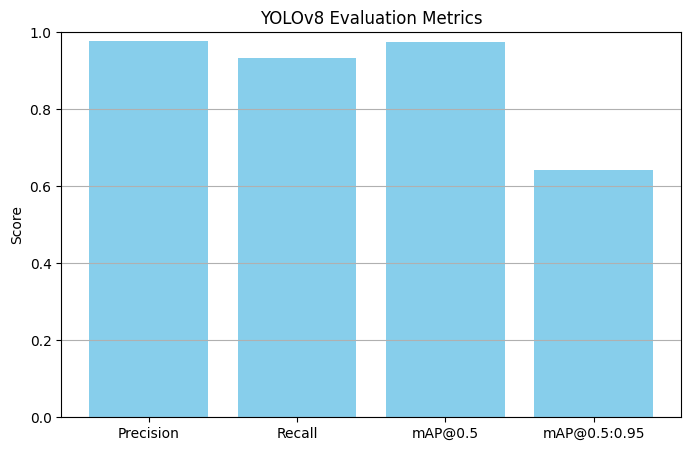

In [8]:
import matplotlib.pyplot as plt

metrics = {
    'Precision': 0.978,
    'Recall': 0.933,
    'mAP@0.5': 0.974,
    'mAP@0.5:0.95': 0.643
}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('YOLOv8 Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()


## Optional: Save Inference Results

In [10]:
# Save results with bounding boxes
output_dir = "Pro_1/runs/detect/inference_results"
for img_name in val_images[:5]:
    img_path = os.path.join(VAL_DIR, img_name)
    model.predict(img_path, save=True, project=output_dir, name="predictions", exist_ok=True)



image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10020.jpg: 384x640 1 car, 85.8ms
Speed: 3.7ms preprocess, 85.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to Pro_1\runs\detect\inference_results\predictions

image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10100.jpg: 384x640 1 car, 53.8ms
Speed: 1.6ms preprocess, 53.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to Pro_1\runs\detect\inference_results\predictions

image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_1040.jpg: 384x640 1 car, 53.7ms
Speed: 1.7ms preprocess, 53.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to Pro_1\runs\detect\inference_results\predictions

image 1/1 D:\DS-Class\Sep_Proj\Pro_1\data\yolo_dataset\images\val\vid_4_10980.jpg: 384x640 2 cars, 57.4ms
Speed: 2.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384

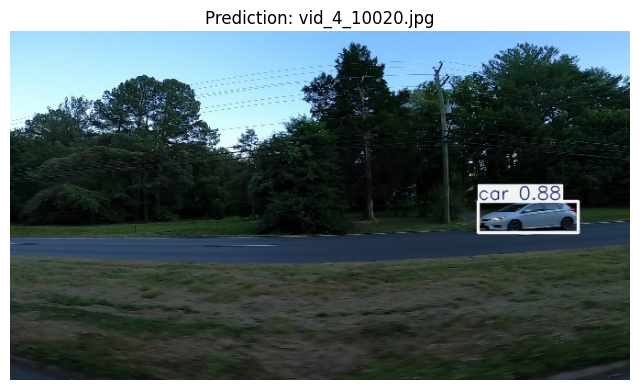

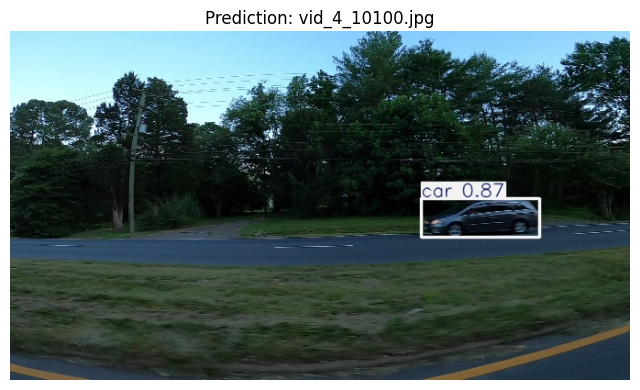

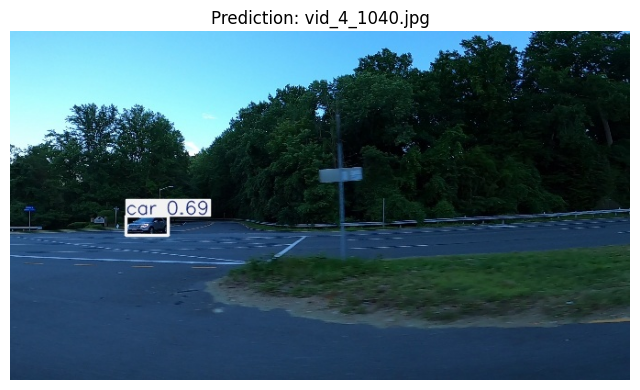

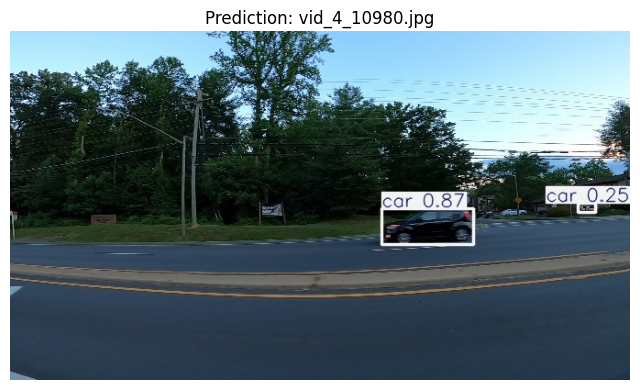

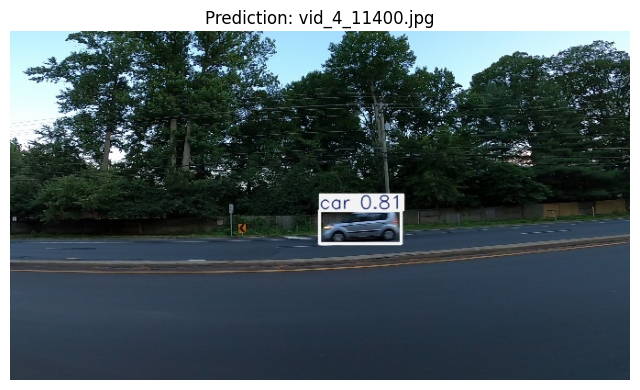

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import os

pred_dir = "Pro_1/runs/detect/inference_results/predictions"  # Folder where YOLOv8 saved predictions

# List saved images (adjust extension if needed)
predicted_images = [f for f in os.listdir(pred_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Show first 5 predicted images
for img_name in predicted_images[:5]:
    img_path = os.path.join(pred_dir, img_name)
    img = Image.open(img_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {img_name}")
    plt.axis("off")
    plt.show()